<a href="https://colab.research.google.com/github/edogriba/NAML-2024/blob/main/LAB03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 03

## Matrix completion


[MovieLens](movielens.umn.edu) data sets were collected by the [GroupLens Research Project](http://www.grouplens.org/) at the University of Minnesota.

This data set consists of:

- 100000 ratings (1-5) from 943 users on 1682 movies.
- Each user has rated at least 20 movies.

The `movielens.csv` file contains the full dataset. Users and items are numbered consecutively from 1. The data is randomly ordered. This is a tab separated list of

```
user id | item id | rating | timestamp
```


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix # useful to store the X matrix which is a big sparse matrix
from scipy.stats import pearsonr # used to implement rho

Read the dataset from the movielens.csv file

In [22]:
dataset = pd.read_csv("movielens.csv", sep="\t", header=None)
dataset.describe()
# dataset.dtypes # useful to understand the type of data we are working with

,0,1,2,3
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


Let's store movies, people and ratings in proper data structures

In [33]:
users = dataset[0] - 1 # adjust indexes
movies = dataset[1] - 1 # adjust indexes
ratings = dataset[2]

n_users = users.unique().size
n_movies = movies.unique().size
n_ratings = len(ratings)

print(f"Number of users {n_users}")
print(f"Number of movies {n_movies}")
print(f"Number of ratings {n_ratings}")

Number of users 943
Number of movies 1682
Number of ratings 100000


Even thought the trace of the exercise says the dataset is already shuffled, as a best practice, we gonna shuffle the data anyway using `np.random.shuffle` \\
*N.T. `np.random.shuffle` it does not return anything, it just changes the number of indices locally*

In [45]:
np.random.seed(1)

indices = np.arange(n_ratings)

np.random.shuffle(indices)

users = users[indices]
movies = movies[indices]
ratings = ratings [indices]


Now we have to split the dataset into training data and testing data

In [49]:
n_training = int(0.8* len(dataset))

users_train = users[:n_training]
movies_train = movies[:n_training]
ratings_train = ratings[:n_training]

users_test = users[n_training:]
movies_test = movies[n_training:]
ratings_test = ratings[n_training:]

Let us denote by $\Omega$ the set of pairs $(i,j)$ such that rating of the $i$-th user on the $j$-th movie is available in the training set (similarly, $\Omega_{\text{test}}$ is the set of testing pairs).
Let us denote by $r_{ij}$ the corresponding rating.

Create a full matrix $X \in \mathbb{R}^{n \times p}$, such that:

$$
X_{i,j} =
\begin{cases}
r_{ij} & \text{if } (i,j) \in \Omega\\
0& \text{otherwise}
\end{cases}
$$

We exploit the sparse representation of the matrix, using scipy.sparse library ( here imported as csr_matrix)

In [52]:
X_sparse = csr_matrix((ratings_train, (users_train, movies_train)), shape=(n_users , n_movies))

X_full = X_sparse.toarray()


### Trivial recommender system

Create a trivial recommender system, based on the average rating of each user:

$$
r^{\text{pred}}_{ij} = \frac{1}{N_i} \sum_{j : (i,j) \in \Omega} r_{ij}
$$

where $N_i = card(j : (i,j) \in \Omega)$.

Then compute the RMSE (root mean square error):

$$
\text{RMSE} = \sqrt{\frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} (r_{ij} - r^{\text{pred}}_{ij})^2}
$$

and the Pearson correlation coefficient $\rho$ (use the function [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)):

$$
\rho =
\frac
{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})
}
{\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})^2
       }
\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})^2
       }}
$$

where

$$
\begin{split}
\overline{r} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r_{ij}
\\
\overline{r}^{\text{pred}} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r^{\text{pred}}_{ij}
\end{split}
$$


In [53]:
avg_ratings = np.array([np.mean(ratings_train[users_train == i]) for i in range(n_users)])
ratings_trivial = avg_ratings[users_test]

errors_trivial = ratings_test - ratings_trivial

RMSE_trivial = np.sqrt(np.mean(errors_trivial**2))
rho_trivial = pearsonr(ratings_test, ratings_trivial)[0]
print(f"RMSE: {RMSE_trivial:1.3f}")
print(f"rho : {rho_trivial:1.3f}")

RMSE: 1.043
rho : 0.384


### Singular value truncation (SVT) based recommender system

Implement the SVT algorithm to predict the ratings of the testing set. Set a maximum number of iterations equal to 100. Print the RMSE and $\rho$ at each iteration. Finally, plot the trend of both metrics.

Try to calibrate the threshold to get better results.



In [61]:
n_max_iter = 100

threshold = 100.0 # Fine tune between 10.0 - 1000.0

increment_tol = 1e-6

RMSE_svt = []
rho_svt = []

# Initialize the matrix X

X = np.copy(X_full) # Actually overmriting the data

for i in range(n_max_iter):
  # SVT Iteration
  X_old = np.copy(X)
  U, s, VT = np.linalg.svd(X, full_matrices=False)
  s[ s < threshold ] = 0
  S = np.diag(s)
  X = U @ S @ VT
  X[users_train, movies_train] = X_full[users_train, movies_train]

  increment = np.linalg.norm(X - X_old)

  # Evaluation of X^k

  predicted_ratings = X[users_test, movies_test]

  error = predicted_ratings - ratings_test

  RMSE_svt.append(np.mean(error**2))

  rho_svt.append(pearsonr(ratings_test, predicted_ratings)[0])

  print(f"Iteration {i}: RMSE: {RMSE_svt[i]}, Rho: {rho_svt[i]} ")

  if (increment < increment_tol):
    break


Iteration 0: RMSE: 6.81808941399749, Rho: 0.3137855489850371 
Iteration 1: RMSE: 4.6927552655968565, Rho: 0.34203988456376405 
Iteration 2: RMSE: 3.6818678495516304, Rho: 0.3638942840384751 
Iteration 3: RMSE: 3.0921642805227973, Rho: 0.3812509122749479 
Iteration 4: RMSE: 2.7066528283387945, Rho: 0.39536485100460445 
Iteration 5: RMSE: 2.435630208777259, Rho: 0.40709210346974545 
Iteration 6: RMSE: 2.23512737073477, Rho: 0.41702205489582944 
Iteration 7: RMSE: 2.08104267018768, Rho: 0.4255661740991386 
Iteration 8: RMSE: 1.9590767911979536, Rho: 0.4330173059054466 
Iteration 9: RMSE: 1.8602250526250883, Rho: 0.4395885405434514 
Iteration 10: RMSE: 1.7785441417725103, Rho: 0.44543851891867536 
Iteration 11: RMSE: 1.7099583194681327, Rho: 0.4506879800707798 
Iteration 12: RMSE: 1.6515820332779874, Rho: 0.4554307110801184 
Iteration 13: RMSE: 1.6013164418838635, Rho: 0.45974091280981144 
Iteration 14: RMSE: 1.5575991487825613, Rho: 0.463678249494916 
Iteration 15: RMSE: 1.519243508163807

<ipython-input-64-c41c44572696>:5: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  axs[0].legend("RMSE", "RMSE trivial")
<ipython-input-64-c41c44572696>:9: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  axs[1].legend(r"$\rho$", r"$\rho$ trivial")


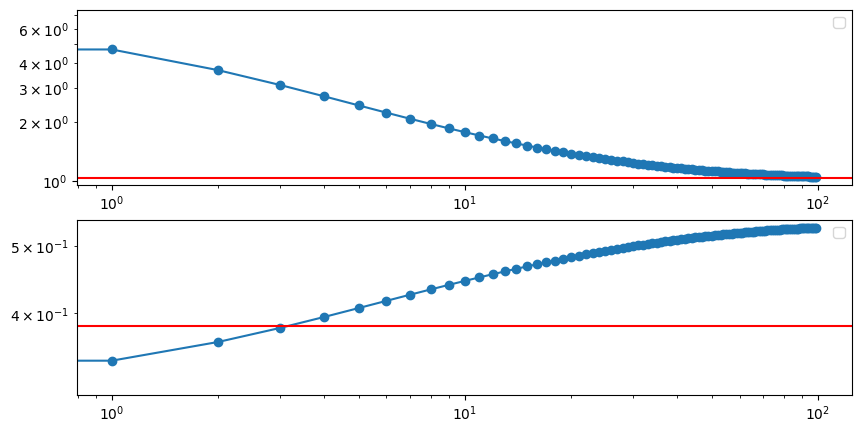

In [64]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))

axs[0].loglog(RMSE_svt, 'o-')
axs[0].axhline(RMSE_trivial, color='r')
axs[0].legend("RMSE", "RMSE trivial")

axs[1].loglog(rho_svt, 'o-')
axs[1].axhline(rho_trivial, color="red")
axs[1].legend(r"$\rho$", r"$\rho$ trivial")

Let's try to speed up the process with rSVD.
Small recap: the Randomized SVD would like tohelp when computing the SVD of a large matrix is computationally heavy.
Usually, indeed, even though the matrix X $ \in R^{nxm}$ is huge it has a low rank structure. The idea is to sample its column space.
Therefore what we do is to create a random matrix $P  \in R^{mxr}$, we multiply it by $A$, getting $Z$. We QR factorize $Z$, and compute $ Y = Q^T A$. Then we apply the SVD on Y and, thanks to the theorems of Random Linear Algebra, we should get $\Sigma_y ≈ \Sigma_x$ and $ V^T_y \approx V^T_y$. To get we must do: $U_x = Q U_y$

In [71]:
# Now I wanna use rSVD
def randomized_SVD(A, k):
  P = np.random.randn(A.shape[1], k)
  Z = A @ P
  Q, _ = np.linalg.qr(Z)
  Y = Q.T @ A
  Uy, s, VT = np.linalg.svd(Y, full_matrices=False)
  U = Q @ Uy
  return U, s, VT


n_max_iter = 100

low_rank_hp = 30 # hypothesis of low rank of matrix X I tried 10, 20 and 30 the last one seems fine

threshold = 100.0 # Fine tune between 10.0 - 1000.0

increment_tol = 1e-6

RMSE_svt = []
rho_svt = []

# Initialize the matrix X

X = np.copy(X_full) # Actually overwriting the data

for i in range(n_max_iter):
  # SVT Iteration
  X_old = np.copy(X)
  U, s, VT = randomized_SVD(X, low_rank_hp)
  s[ s < threshold ] = 0
  S = np.diag(s)
  X = U @ S @ VT
  X[users_train, movies_train] = X_full[users_train, movies_train]

  increment = np.linalg.norm(X - X_old)

  # Evaluation of X^k

  predicted_ratings = X[users_test, movies_test]

  error = predicted_ratings - ratings_test

  RMSE_svt.append(np.mean(error**2))

  rho_svt.append(pearsonr(ratings_test, predicted_ratings)[0])

  print(f"Iteration {i}: RMSE: {RMSE_svt[i]}, Rho: {rho_svt[i]} ")

  if (increment < increment_tol):
    break


Iteration 0: RMSE: 8.49015133652107, Rho: 0.2352957415792747 
Iteration 1: RMSE: 6.026694252318358, Rho: 0.27476948458715045 
Iteration 2: RMSE: 4.898875937663435, Rho: 0.2910681749873286 
Iteration 3: RMSE: 4.1043285787831865, Rho: 0.3139402790628346 
Iteration 4: RMSE: 3.5614225918605857, Rho: 0.3284763793743462 
Iteration 5: RMSE: 3.1738027793101167, Rho: 0.33862075737920894 
Iteration 6: RMSE: 2.8602792409558804, Rho: 0.3490522678399817 
Iteration 7: RMSE: 2.614395188840647, Rho: 0.3643188823564912 
Iteration 8: RMSE: 2.4422091559894588, Rho: 0.3720794723512335 
Iteration 9: RMSE: 2.291366991928945, Rho: 0.3813474128184956 
Iteration 10: RMSE: 2.1655671020222202, Rho: 0.3906018920522264 
Iteration 11: RMSE: 2.054040033532216, Rho: 0.39946324656431326 
Iteration 12: RMSE: 1.9699235242222979, Rho: 0.4058122404460965 
Iteration 13: RMSE: 1.8747659550306903, Rho: 0.4133294277739262 
Iteration 14: RMSE: 1.8194838926672259, Rho: 0.4135289014768666 
Iteration 15: RMSE: 1.7659442348560719,

## Moore-Penrose Pseudo-Inverse


In [70]:
import scipy.linalg as la

A function computing the Moore-Penrose Pseudo-Inverse, exploiting the full SVD


In [80]:
def my_pinv_fullSVD(A):
  U, s, VT = np.linalg.svd(A, full_matrices=True)
  s[s > 0] = 1 / s[s > 0]
  return (VT.T)@ la.diagsvd(s, A.shape[1], A.shape[0]) @ U.T

A function computing the Moore-Penrose Pseudo-inverse, exploiting the thin SVD

In [81]:
def my_pinv_thinSVD(A):
  U, s, VT = np.linalg.svd(A, full_matrices=False)
  s[s > 0] = 1 / s[s > 0]
  return (VT.T * s) @ U.T # this is faster since it uses broadcasting

Next we create a random matrix A $ \in R^{5x4}$. we compute its Moore-Penrose inverse with the two commands created by us and compare the runtime with the command from the library `numpy.linalg.pinv()` thank to Colab command `%timeit`

In [82]:
A = np.random.randn(5, 4)


%timeit my_pinv_fullSVD(A)
%timeit my_pinv_thinSVD(A)
%timeit np.linalg.pinv(A)

A1 = my_pinv_fullSVD(A)
A2 = my_pinv_thinSVD(A)
A3 = np.linalg.pinv(A)

print(A1.shape,
A2.shape,
A3.shape)

print(np.linalg.norm(A3 - A2)/np.linalg.norm(A3))
print(np.linalg.norm(A3 - A1)/np.linalg.norm(A3))


60.4 µs ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
30.4 µs ± 980 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
43.3 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
(4, 5) (4, 5) (4, 5)
9.464449792477549e-17
9.464449792477549e-17


## Least-Square Regression



Consider the linear model

$$
y = mx + q.
$$

where $m = 2$ and $q = 3$.

Generate $N = 100$ points $x_i$, sampling from a standard Gaussian distribution, and the associated $y_i$. Then, add a synthetic noise ($\epsilon_i$) by sampling from a Gaussian distribution with zero mean and standard deviation $\sigma = 2$. Plot the noisy data $(x_i, \tilde{y}_i)$, where $\tilde{y}_i = y_i + \epsilon_i$, in the $(x,y)$ plane, together with the line $y = mx + q$.

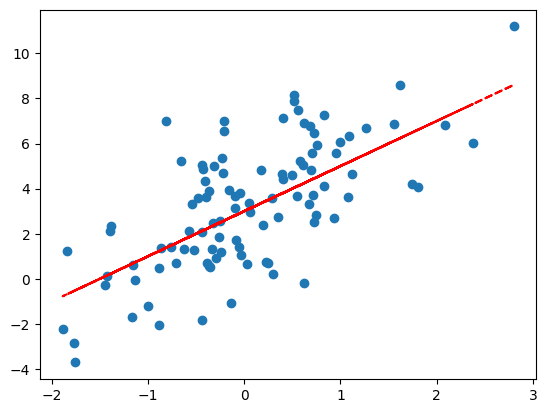

In [87]:
N = 100

m = 2

q = 3

x = np.random.randn(N)

mu = 0

sigma = 2

e = sigma * np.random.randn(N) + mu

yn = m*x+q+e

plt.scatter(x, yn)
plt.plot(x, m*x+q, 'r--')

Using the previously implemented functions to compute the Moore-Penrose pseudo inverse, solve the least-squares problem

$$
\min_{m,q} \sum_{i=1}^N (\tilde{y}_i - (m x_i + q))^2
$$

and display the regression line superimposed to the noisy data and the exact model.


predicted m : 2.12, correct m : [2]
predicted m : 3.15, correct q : [3]


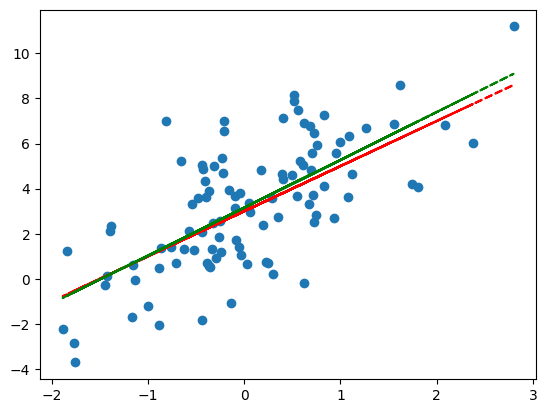

In [93]:
Phi = np.hstack([x[:, None], np.ones((N, 1))]) # we are stacking horizontally two column vectors
w = my_pinv_thinSVD(Phi) @ yn
print(f'predicted m : {w[0]:.2f}, correct m : {[m]}')
print(f'predicted q : {w[1]:.2f}, correct q : {[q]}')

plt.scatter(x, yn)
plt.plot(x, m*x+ q, 'r--')
plt.plot(x, w[0]*x + w[1], 'g--')

Now let's use the normal equation. We basically get the same result

In [96]:
w2 = np.linalg.solve(Phi.T @ Phi, Phi.T @ yn)
print(np.linalg.norm(w-w2))

1.4043333874306805e-15


## Ridge Regression

Consider the function

$$
y = f(x) = \tanh(2x - 1).
$$

Generate $N = 100$ points $x_i$, sampling from a standard Gaussian distribution, and the associated $y_i$. Then, add a synthetic noise ($\epsilon_i$) by sampling from a Gaussian distribution with zero mean and standard deviation $\sigma = 0.1$. Plot the noisy data $(x_i, \tilde{y}_i)$, where $\tilde{y}_i = y_i + \epsilon_i$, in the $(x,y)$ plane.

Then, generate 1000 testing points, uniformly distributed in the interval $[-3,3]$, and display the function $y = f(x)$ in correspondence of the testing points.


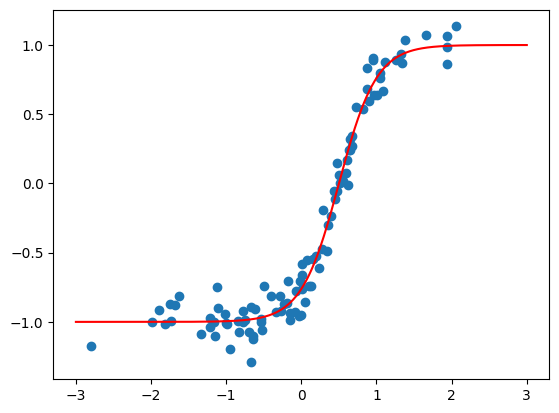

In [108]:
N = 100

M = 1000

x1 = np.random.randn(N)

x2 = np.linspace(-3, 3, M)

sigma = 0.1

mu = 0

e = mu + sigma * np.random.randn(N)

y1 = np.tanh(2*x1-np.ones(N))

y2 = np.tanh(2*x2-np.ones(M))

yn = y1 + e

plt.scatter(x1, yn)
plt.plot(x2, y2, 'r-')

Proceeding as in the previous exercise, let's compute the regression line from the least square method. We will see that it won't work


predicted m : 0.66, correct m : [2]
predicted q : -0.33, correct q : [3]


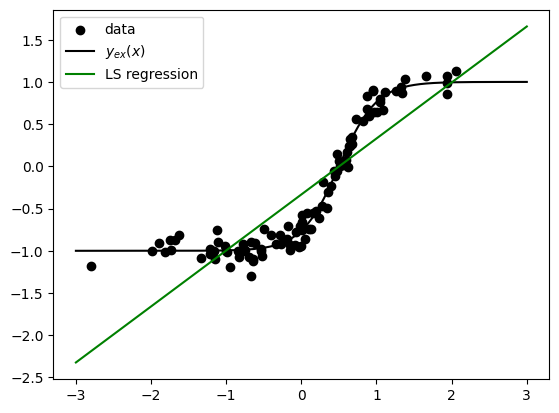

In [112]:
Phi = np.hstack([x1[:, None], np.ones((N, 1))])

w = np.linalg.pinv(Phi) @ yn

print(f'predicted m : {w[0]:.2f}, correct m : {[m]}')
print(f'predicted q : {w[1]:.2f}, correct q : {[q]}')

y_ls = w[0] * x2 + w[1]

plt.scatter(x1, yn, color="black", label="data")
plt.plot(x2, y2, color="black", label="$y_{ex}(x)$")
plt.plot(x2, y_ls, color="green", label="LS regression")
plt.legend()



Let us now consider **ridge regression**, corresponding to a regularizaton parameter $\lambda = 1.0$. Compare the obtained regression line with the one obtained through least squares regression.


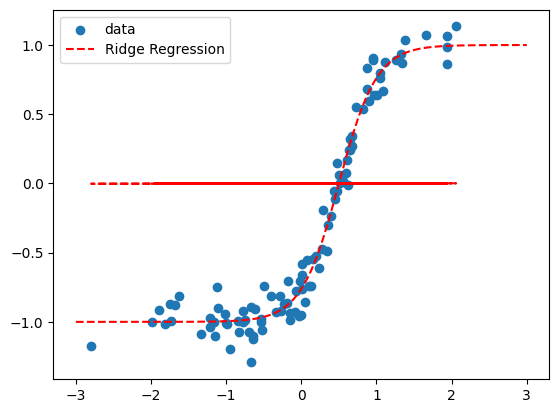

In [118]:
lam = 1.0 # this is the penalization term the bigger the more horizontal is the ridge regression line

alpha = np.linalg.solve(Phi @ Phi.T + lam * np.eye(N), yn)

w = Phi.T @ alpha

Phi_test = np.hstack([x1[:, None], np.ones((N, 1))])

y_rr = Phi_test @ w

plt.scatter(x1, yn, label='data')
plt.plot(x2, y2, "r--")
plt.plot(x1, y_rr, "r--", label='Ridge Regression')

plt.legend()

## Kernel Regression

Consider now **kernel regression**.

1. Consider first the scalar product kernel
   $$K(x_i,x_j) = x_i x_j + 1.$$
   Compute the regression function and compare the result with the ones obtained at the previous point. How do the results compare?

2. Consider then the higher-order scalar product kernel, for $q > 1$.
   $$K(x_i,x_j) = (x_i x_j + 1)^q.$$

3. Consider finally a Gaussian kernel, for $\sigma > 0$.
   $$K(x_i,x_j) = \exp\left(-\frac{(x_i - x_j)^2}{2 \sigma^2}\right).$$


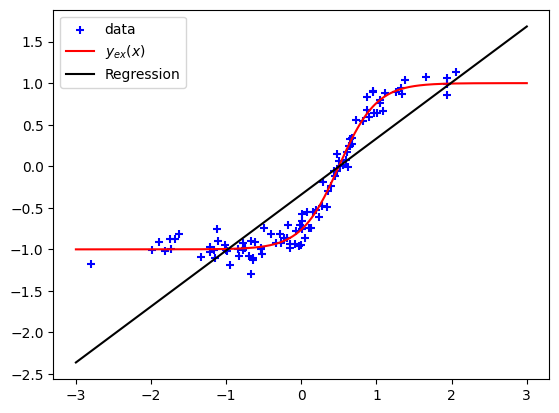

In [137]:
lam = 1.0
# Scalar Product
def scalar_product_kernel(xi, xj):
  return xi + xj + 1

k = np.array([[scalar_product_kernel(x1[i], x1[j]) for j in range(N)] for i in range(N)])

alpha = np.linalg.solve(k + lam * np.eye(N), yn)

k_test = np.array([[scalar_product_kernel(x2[i], x1[j])for j in range(N)] for i in range(M)])

y_sp_kr = k_test @ alpha

plt.scatter(x1, yn, marker="+", color="blue", label="data")
plt.plot(x2, y2, color="red", label="$y_{ex}(x)$")
plt.plot(x2, y_sp_kr, color="black", label="Regression")
plt.legend()

(-2.0, 2.0)

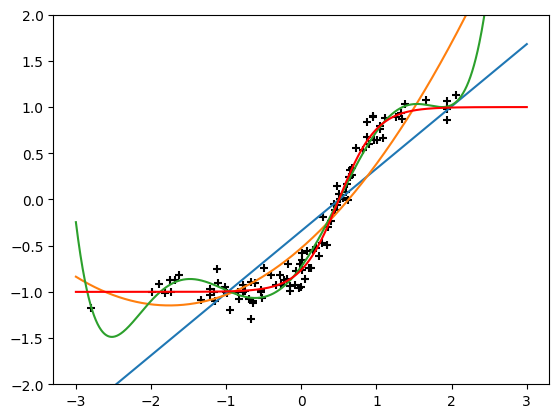

In [136]:
# Higher Order Scalar Product

lam = 1.0

def ho_scalar_product_kernel(q, xi, xj):
  return (xi + xj + 1)**q

for q in [1, 2, 6]:
  k = np.array([[ho_scalar_product_kernel(q, x1[i], x1[j]) for j in range(N)] for i in range(N)])

  alpha = np.linalg.solve(k + lam * np.eye(N), yn)

  k_test = np.array([[ho_scalar_product_kernel(q, x2[i], x1[j])for j in range(N)] for i in range(M)])

  y_sp_kr = k_test @ alpha

  plt.plot(x2, y_sp_kr)


plt.scatter(x1, yn, marker="+", color="black", label="data")
plt.plot(x2, y2, color="red", label="$y_{ex}(x)$")
plt.ylim([-2, 2])

(-2.0, 2.0)

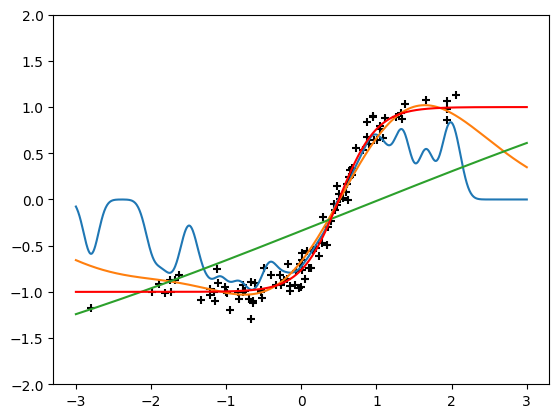

In [140]:
# Gaussian Kernel Regression

def gaussian_kernel(sigma, xi, xj):
  return np.exp(-np.abs(xi-xj)**2/(2*sigma**2))

for sigma in [0.1, 1.0, 10.0]:
  k = np.array([[gaussian_kernel(sigma, x1[i], x1[j]) for j in range(N)] for i in range(N)])

  alpha = np.linalg.solve(k + lam * np.eye(N), yn)

  k_test = np.array([[gaussian_kernel(sigma, x2[i], x1[j]) for j in range(N)] for i in range(M)])

  y_gauss_kr = k_test @ alpha

  plt.plot(x2, y_gauss_kr)

plt.scatter(x1, yn, marker="+", color="black", label="data")
plt.plot(x2, y2, color="red", label="$y_{ex}(x)$")
plt.ylim([-2, 2])

